# Practicing with pymc

Working with pymc can be difficult. All programming problems force you to engage with obscure errors but pymc errors can be especially obscure. We can help you, Akshay and I. But the best approach is to just run head first into a few and practice correcting your code. I want to start off class today by repeating an exercise from last lecture, except you'll do half of it on your own. 

Below is code to (1) extract the treatment group data and (2) estimate the beta-binomial model on that data. Your job is to extract the control group data and estimate the beta-binomial model on that. Then we'll compare the two groups. Solutions for all of this can be found in Lecture 13 so if you get stuck, that's a place to check. But try to do as much on your own.

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pymc as pm
import arviz as az

url = "https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/Asch_experiment_1_data"

data = pd.read_csv(url)
data

,treatment,mistakes
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
82,0,0
83,0,0
84,0,0
85,0,1


Below is how we extract the treatment group. But how do we extract the control group data?

In [10]:
n = 12

# treatment group

data_treatment = data[data.treatment == 1]
k_treatment = list(data_treatment.mistakes.values)

In [ ]:
# control group

Here is the pymc code to estimate the beta-binomial on the treatment. What changes do we need to make to estimate the control? It would be really nice if we could compare the two models later on, so try to write your code so it doesn't save over names we used in the first estimation.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, d]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


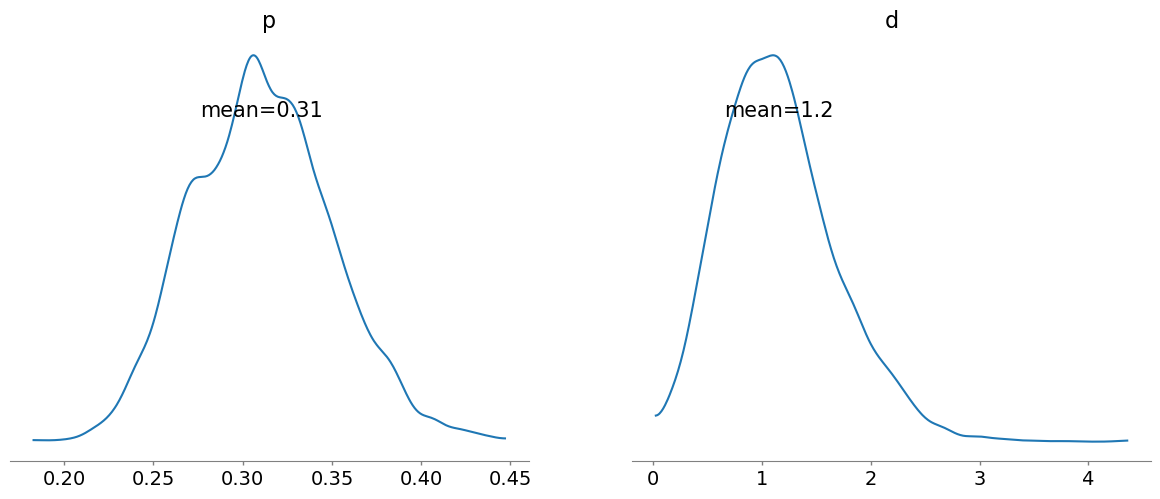

In [11]:
with pm.Model() as m1:
    p = pm.Beta('p',alpha=1,beta=1)
    d = pm.Exponential('d',1/150) + 1
    
    a = p*d
    b = (1-p)*d
    
    y = pm.BetaBinomial('y',n=12,alpha=a,beta=b,observed=k_treatment)
    
    trace1 = pm.sample()
    
az.plot_posterior(trace1,hdi_prob='hide');

In [ ]:
# control group

Finally we want to compare the two groups. This entails taking the posterior distributions over both parameters and pushing them through a `stats.betabinom().rvs()` function to create predictions for future hypothetical experiments. Try to get predictions for both groups.

Finally, we want to get a histogram to compare the two sets of predictions. Subtract one batch of predictions from the other and plot it.

# Thinking forwards and backwards

At this point in the course, you might have started to notice a pattern in how we work through problems. Usually we start with some dataset, think about possible explanations or causes, convert those explanations into simulations, use the simulations to pick out a Bayesian model, define some priors, get estimates and then use those estimates to get predictions. That's a lot of steps and they can start to blur together. It would be helpful if we had some kind of conceptual tool for organizing the process.

One way I like to think about it is that we have two directions of modeling. We can reason from possible underlying causes to what the data should look like. This is what we do when we write a simulation. We'll call this the forward direction and it's usually easier. Then we can reason from data to infer things about the underlying causes look like. We'll call this the backward the direction and it's usually harder. This diagram might be helpful:

![backward_and_forward.png](https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/backward_and_forward.png)

In green, I've highlighted the main components of the forward direction. We might have causal mechanisms combined with some parameter values. Together, they generate predictions. In blue, we have the data. That's the only part of the process we ever observe. In orange, I've highlighted the main components of the backward direction. We have the data but we do not know the causal mechanisms or the parameter values that generate them. So we have to make up stories about possible mechanism + what we think about what are plausible parameter values to combine with those mechanisms. At this point we can apply bayes theorem to get a posterior distribution of parameters. Finally, everything loops. Once we have posterior distributions, we can combine those with causal mechanisms to get new predictions. Those posterior distributions can also be reused in future analyses to inform our prior distributions.

This way of thinking can help us answer all sorts of basic questions about how our research strategies behave under various circumstances. Our main question today is about sample sizes - what counts as a big enough sample size? What assumptions do we have to make in order to be able to tell? Our strategy will be to exploit backward and forward thinking to answer those questions. 

We'll proceed in two steps: first, we'll design a little artificial world where we know all the causal mechanisms and all the parameter values. We'll fill this world up with data. Second, we'll apply our bayesian inference strategy to this world and figure out how well it is able to learn the features of our artifical world. By varying our assumptions about the artificial world, we can see best case and worst case behaviors for your bayesian inference strategy.

## Sample size in the asch study

The Asch study had 50 people in the treatment group. Our question is: is 50 people enough? We can answer this question by exploiting both backward and forward thinking. First, we build a world. Our world should have 50 people. Then we should specify the parameter values and causal mechanisms operating in this world. The causal mechanism is a beta-binomial process - people in the treatment group make errors but there can be substantial spread in how many errors each person makes. We'll pick an error rate of `p = 0.5` and `d = 10`. These numbers are pretty arbitrary - that's okay. The goal is just to see if the Bayesian inference strategy can correctly guess that these were our numbers.

Below is code to simulate our little world.

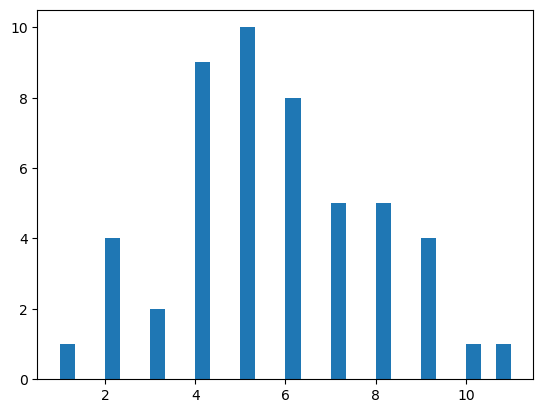

In [13]:
sample_size = 50
p = 0.5
d = 10

data = stats.betabinom(n=12,a=p*d,b=(1-p)*d).rvs(sample_size)

plt.hist(data,bins=30);

Okay with this batch of simulated data, the question is, can our Bayesian model learn the right parameter values. If it doesn't, how far off does it get?

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, d]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


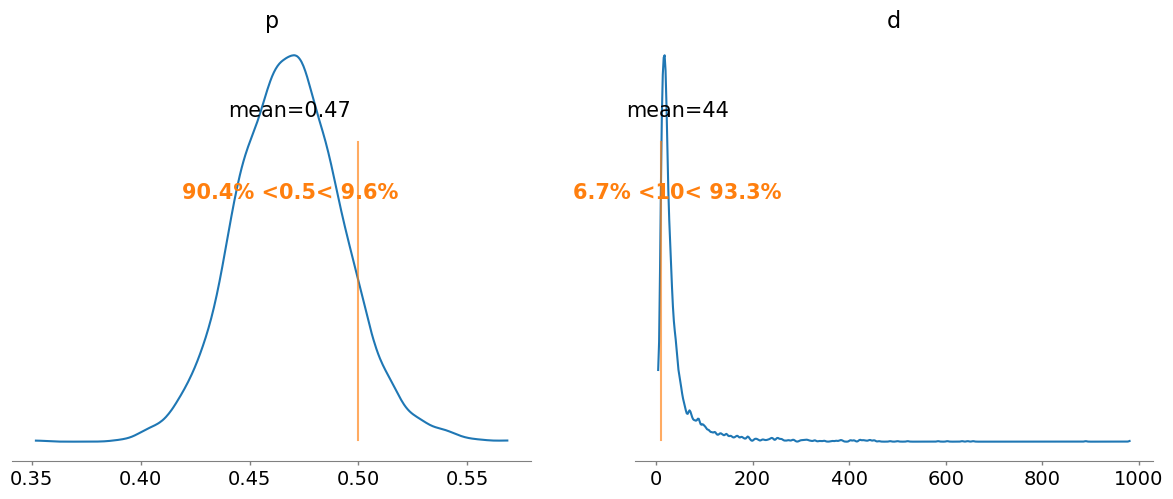

In [14]:
with pm.Model() as m0:
    p = pm.Beta('p',alpha=1,beta=1)
    d = pm.Exponential('d',1/150) + 1
    
    a = p*d
    b = (1-p)*d
    
    y = pm.BetaBinomial('y',n=12,alpha=a,beta=b,observed=data)
    
    trace = pm.sample()
    
az.plot_posterior(trace,ref_val=[0.5,10.0],hdi_prob='hide');

I've added vertical lines to indicate where the true values are. You can see that our model isn't totally sure where the parameter is supposed to be. You'll see different stuff each time you run the estimator. But on this run, the posterior distribution over `p` puts 0.47 as the best guess and ranges roughly from 0.4-0.55. Remember, the right answer is 0.5. So the right answer is solidly in the range of things the posterior thinks is possible. But the posterior best guess is a bit off.

In the `d` parameter is worse off. The best guess (the mean of the posterior) is 44 but the right answer is 10. To some extent, this isn't so bad. We know the dispersion parameter has some odd features which makes it fairly asymmetrical. Even if it puts the mean of the distribution around 40, that means a lot of the distribution says there should be a bunch of dispersion. Remember, when we assigned a exponential prior with mean 150, that essentially said there is an equal chance of dispersion or no dispersion. So the fact that it shifts back down to 40 is a sign it's learning the right answer.

Naturally, you might want to know the answer to the question: is 50 a good sample size? Let's hold off for a minute and repeat this example. We'll generate a new simulated dataset. Each time we generate a simulated dataset, it will be slightly different. This is because there is random variation in how each of our 50 people perform.

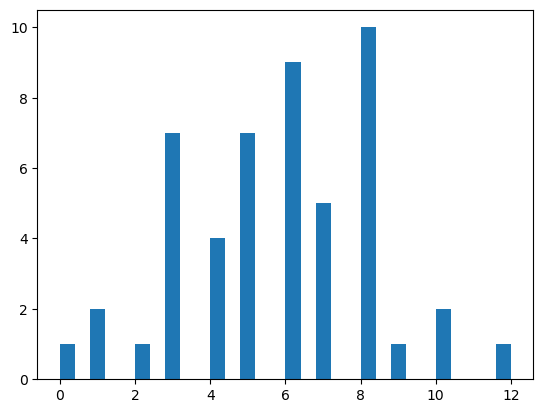

In [15]:
sample_size = 50
p = 0.5
d = 10

data = stats.betabinom(n=12,a=p*d,b=(1-p)*d).rvs(sample_size)

plt.hist(data,bins=30);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, d]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


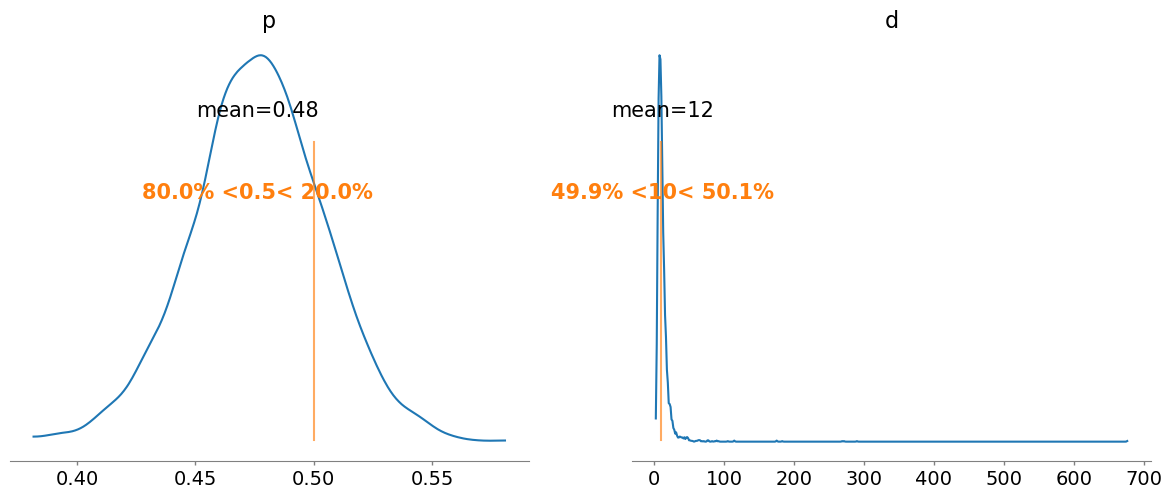

In [16]:
with pm.Model() as m0:
    p = pm.Beta('p',alpha=1,beta=1)
    d = pm.Exponential('d',1/150) + 1
    
    a = p*d
    b = (1-p)*d
    
    y = pm.BetaBinomial('y',n=12,alpha=a,beta=b,observed=data)
    
    trace = pm.sample()
    
az.plot_posterior(trace,ref_val=[0.5,10.0],hdi_prob='hide');

Two things to learn: first, there will be variability across our simulations. Each time you run it, you get a different picture about how a hypothetical experiment might go. Your estimate might go too high on some runs or too low on other runs. You might get more or less certainty in the posterior distribution each time you try it. This is all normal. The lesson is that if you want to study what a good sample size is, you'll want to run this little cycle of backward and forward inference multiple times.

Second, the dispersion parameter got a much better estimate this time. The mean is 12 and the real answer is 10. So our technique can get a good estimate if we have a bit of good luck on the simulated sample.

Now our real question: is this a big enough sample size? The right answer is that this isn't a very good question. Big enough for what? With Bayesian inference, we just get continuous levels of uncertainty. If we don't really mind not knowing whether the right answer is 0.4 or 0.55 for `p`, this is okay. But if we want to narrow it down to a tighter range, then we need a bigger sample size.

What level of uncertainty is desirable depends a lot on our goals and the demands of our research community. There is no such thing as a "bad" amount of uncertainty independent of a really specific research context. So it's hard to give advise in the abstract. We'll see an example in a minute where the goals are more clear.

Let's look at how our tool performs with giant sample sizes.

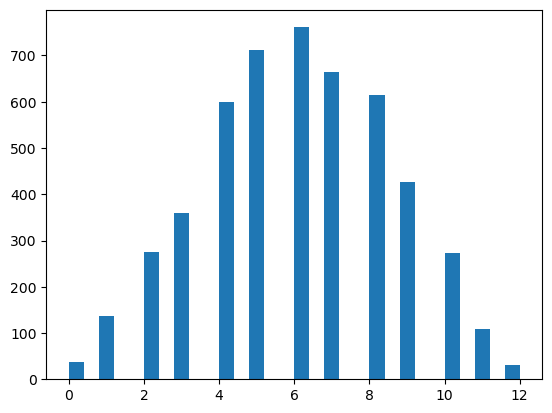

In [17]:
sample_size = 5000
p = 0.5
d = 10

data = stats.betabinom(n=12,a=p*d,b=(1-p)*d).rvs(sample_size)

plt.hist(data,bins=30);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, d]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


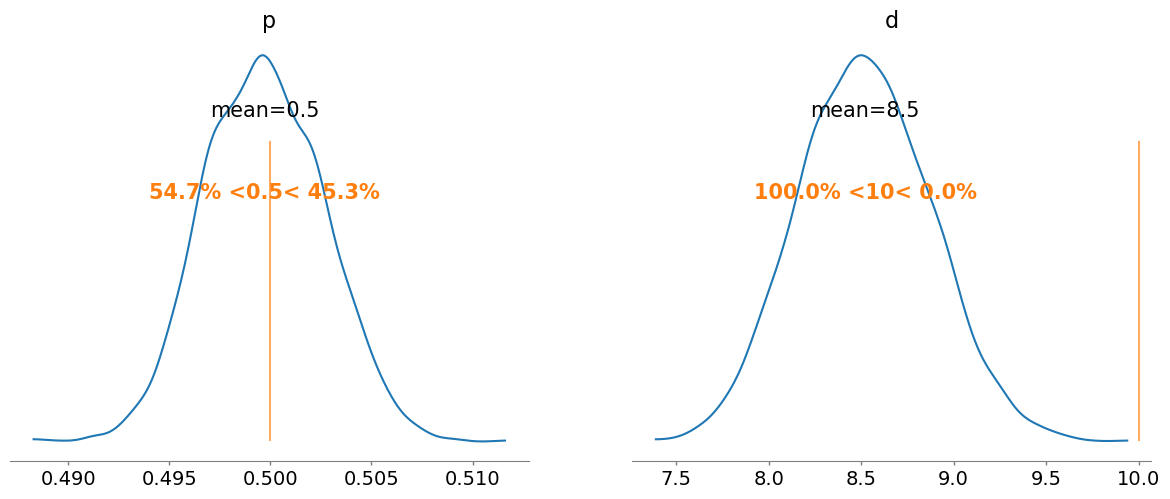

In [18]:
with pm.Model() as m0:
    p = pm.Beta('p',alpha=1,beta=1)
    d = pm.Exponential('d',1/150) + 1
    
    a = p*d
    b = (1-p)*d
    
    y = pm.BetaBinomial('y',n=12,alpha=a,beta=b,observed=data)
    
    trace = pm.sample()
    
az.plot_posterior(trace,ref_val=[0.5,10.0],hdi_prob='hide');

The precision around `p` is really high. Our inference engine has narrowed the correct answer down to between 0.49 and 0.51 and put its best guess on the true answer. 

`d` looks weird. Why is the mean of the posterior well below 10? It's not really a problem - it arises because of that little `+1` we stuck onto the prior distribution. The parameter you are looking at needs to be shifted up by one. We can fix the visualization with some tricks in pymc.

`pm.Deterministic()` lets you do just regular arthimetic calculations but save to one of the pymc's named variables. The whole advantage to this new code is that it lets us access `d` directly when it goes time to make visualizations.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, d_minus_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


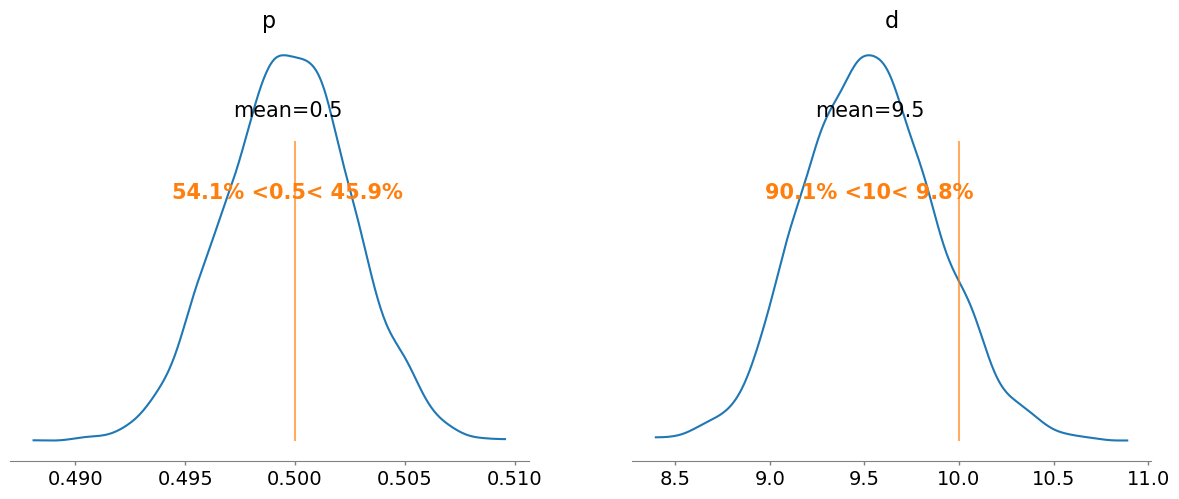

In [20]:
with pm.Model() as m0:
    p = pm.Beta('p',alpha=1,beta=1)
    d_minus_one = pm.Exponential('d_minus_one',1/150)
    d = pm.Deterministic('d',d_minus_one + 1)
    
    a = p*d
    b = (1-p)*d
    
    y = pm.BetaBinomial('y',n=12,alpha=a,beta=b,observed=data)
    
    trace = pm.sample()
    
az.plot_posterior(trace,var_names=['p','d'],ref_val=[0.5,10.0],hdi_prob='hide');

The new graph looks better but `d` is still performing worse than `p`. This is very normal. Parameter that tell us the center of distributions are usually very easy to learn. Parameters that tell us the spread of things are usually a bit harder to learn. We'll see this same phenomena when we discuss normal distributions.

## Sample size and effect size

Normally, we are not interested in just learning the parameter for one group of people. In your typical cognitive science experiment, we are interested in *comparing* two groups. Let's apply the same technique to comparisons. The goal is to figure out, how different the error rates of these two groups of people.

In [24]:
# specify group 1

sample_size_1 = 50
p1 = 0.5
d1 = 10

# specify group 2

sample_size_2 = 34
p2 = 0.4
d2 = 50

# simulate data for both

data1 = stats.betabinom(n=12,a=p1*d1,b=(1-p1)*d1).rvs(sample_size_1)
data2 = stats.betabinom(n=12,a=p2*d2,b=(1-p2)*d2).rvs(sample_size_2)

We can use our simulation as a template for filling out the `pymc` model. Specify a prior on each of `p1, d1, p2, d2`. Do everything else twice.

In [25]:
with pm.Model() as m0:
    p1 = pm.Beta('p1',alpha=1,beta=1)
    d1 = pm.Exponential('d1',1/150) + 1
    p2 = pm.Beta('p2',alpha=1,beta=1)
    d2 = pm.Exponential('d2',1/150) + 1
    
    a1 = p1*d1
    b1 = (1-p1)*d1
    a2 = p2*d2
    b2 = (1-p2)*d2
    
    y = pm.BetaBinomial('y1',n=12,alpha=a1,beta=b1,observed=data1)
    y = pm.BetaBinomial('y2',n=12,alpha=a2,beta=b2,observed=data2)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p1, d1, p2, d2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


The engine works just fine.

The posteriors are pretty interesting. We know for a fact these two groups have different error rates. We designed our world to have this feature. But the Bayesian inference engine isn't so sure. For `p1`, the bottom of the distribution is around 0.4-0.44. For `p2`, the top of the distribution is 0.46 and 0.5. In other words, they overlap. In other other words, the posteriors distributions are not completely sure these groups have different error rates.

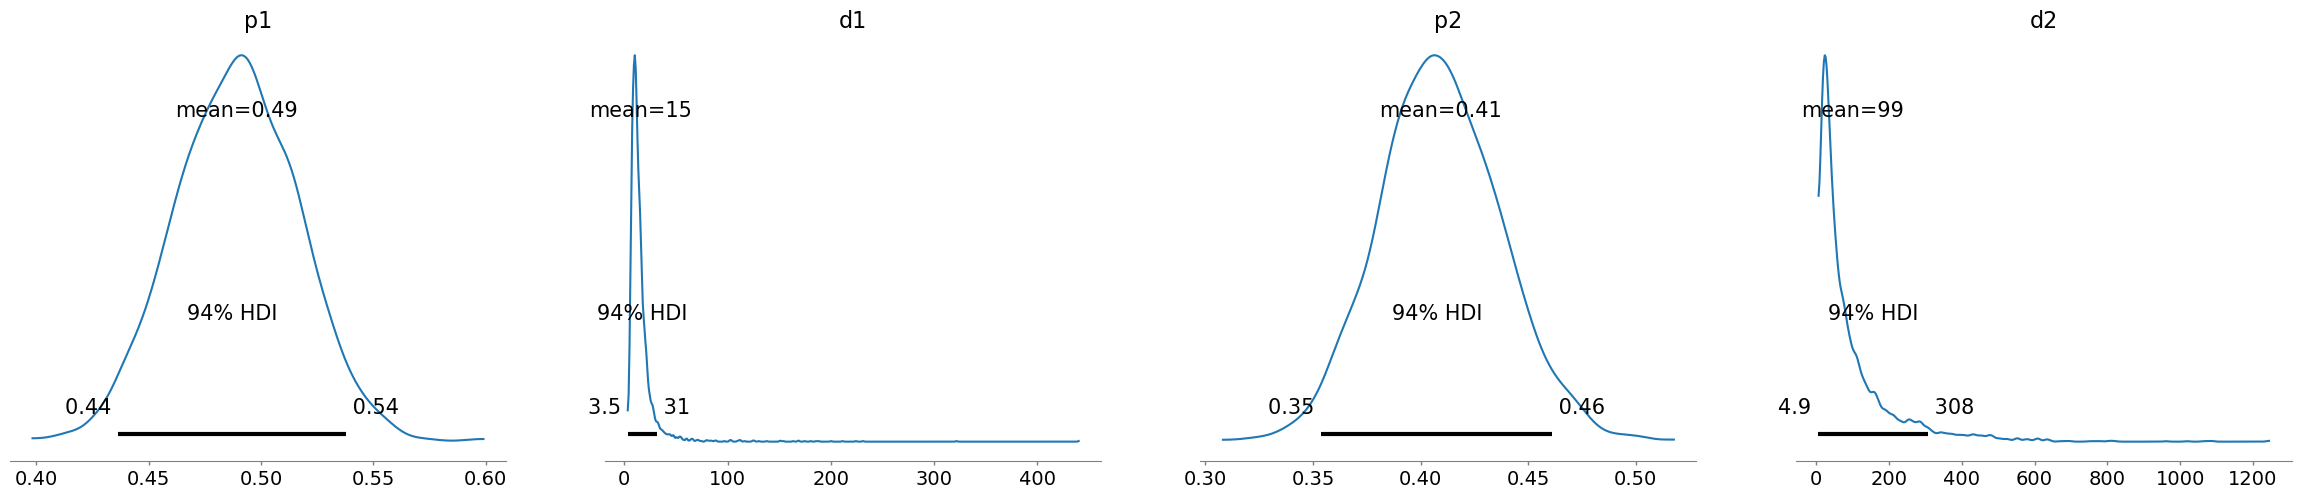

In [26]:
az.plot_posterior(trace);

Here is another way of illustrating the same point - we can subtract the posterior distributions to get a histogram of differences. This a picture of how different our Bayesian inference machine thinks the two distributions are. When they are very very similar, the histogram will stack up near zero. When they are very different, the histogram will stack up far away from zero.

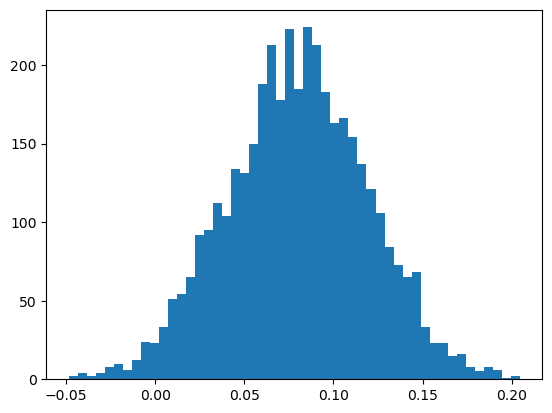

In [30]:
p1 = trace.posterior['p1'].values.flatten()
p2 = trace.posterior['p2'].values.flatten()

plt.hist(p1-p2,bins=50);

So the bulk of the distribution thinks there is a difference but a small tail of our posterior thinks they have same error rate.

This isn't a totally fair comparison. Our knowledge of each group is not summarized by the `p` parameter alone. The disperison parameter can matter too. So our best course of action is to generate posterior predictions and compare them. We've done this before but the plan is to take samples of parameters from our posterior distribution and push them into the betabinomial model. It should look a lot like the coding of our `pymc` model but we use our posterior distributions instead of prior distributions.

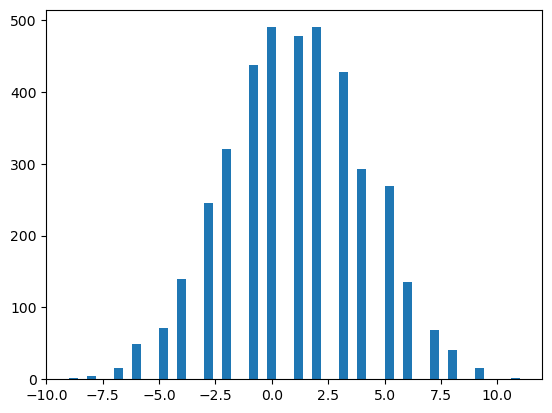

In [31]:
p1 = trace.posterior['p1'].values.flatten()
d1 = trace.posterior['d1'].values.flatten()
p2 = trace.posterior['p2'].values.flatten()
d2 = trace.posterior['d2'].values.flatten()

a1 = p1*d1
b1 = (1-p1)*d1
a2 = p2*d2
b2 = (1-p2)*d2

g1 = stats.betabinom(n=12,a=a1,b=b1).rvs()
g2 = stats.betabinom(n=12,a=a2,b=b2).rvs()

plt.hist(g1 - g2,bins=50);

If we took a random person from each group and put them in our experiment, this histogram shows how many more mistakes we should expect the treatment group folks to make compared to the control group folks. The big insight is that, in repeated experiments, we might not be able to tell which group is which. The control group and treatment group make similar numbers of mistakes, once we account for their levels of dispersion. 

Let's get back to our initial question: if we had two groups with these sample sizes, could we clearly identify their parameters? Could we clearly show these groups should have different predicted numbers of errors?

    sample_size_1 = 50
    p1 = 0.5
    d1 = 10

    sample_size_2 = 34
    p2 = 0.4
    d2 = 50
    
The short answer is - not really. We would detect a little bit of evidence but not very decisive evidence.

One lesson here is that what counts as a good sample size can depend heavily on the *effect size*. The effect size specifies how big the difference between the groups' error rates are. If the effect size is very large (there is a big difference in the error rates) then you don't need super big sample to identify it. So we'll design a new simulation where the treatment group has an error rate of `0.5` and the treatment group has an error rate of `0.05`

In [34]:
# specify group 1

sample_size_1 = 50
p1 = 0.5
d1 = 10

# specify group 2

sample_size_2 = 34
p2 = 0.05
d2 = 50

We'll short cut all the steps in one code block here.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p1, d1, p2, d2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


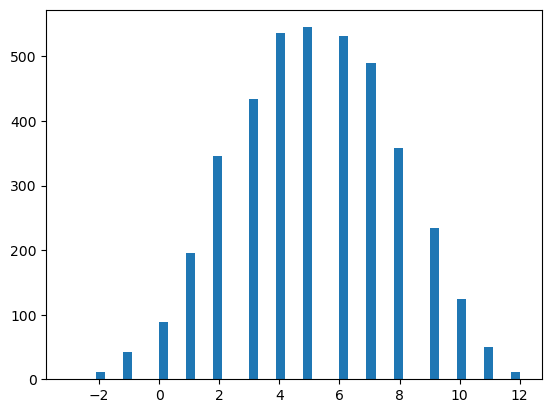

In [35]:
# simulate data for both

data1 = stats.betabinom(n=12,a=p1*d1,b=(1-p1)*d1).rvs(sample_size_1)
data2 = stats.betabinom(n=12,a=p2*d2,b=(1-p2)*d2).rvs(sample_size_2)

with pm.Model() as m0:
    p1 = pm.Beta('p1',alpha=1,beta=1)
    d1 = pm.Exponential('d1',1/150) + 1
    p2 = pm.Beta('p2',alpha=1,beta=1)
    d2 = pm.Exponential('d2',1/150) + 1
    
    a1 = p1*d1
    b1 = (1-p1)*d1
    a2 = p2*d2
    b2 = (1-p2)*d2
    
    y = pm.BetaBinomial('y1',n=12,alpha=a1,beta=b1,observed=data1)
    y = pm.BetaBinomial('y2',n=12,alpha=a2,beta=b2,observed=data2)
    
    trace = pm.sample()
    
p1 = trace.posterior['p1'].values.flatten()
d1 = trace.posterior['d1'].values.flatten()
p2 = trace.posterior['p2'].values.flatten()
d2 = trace.posterior['d2'].values.flatten()

a1 = p1*d1
b1 = (1-p1)*d1
a2 = p2*d2
b2 = (1-p2)*d2

g1 = stats.betabinom(n=12,a=a1,b=b1).rvs()
g2 = stats.betabinom(n=12,a=a2,b=b2).rvs()

plt.hist(g1 - g2,bins=50);

Now our inferential engine is very confident that the treatment group should make more mistakes than the control group. Remember, we use exactly the same sample sizes in this simulation vs. the previous one. All we did was adjust the effect size.

Let's keep track of the morals from today:

1. No such thing a good sample size independent of the research context. Bayesian inference provides us continuous shades of uncertainty and we cannot clearly divide good level of uncertainty from a bad level of uncertainty. It depends on our interests and the interests of the scientific community.
2. What counts as a good sample size (for a given goal) also depends on the effect size. If you think the effect size should be large, a smaller sample is okay. If you think the effect size should be small, a bigger sample is necessary.

## How to run prospective sample size studies

There is a very practical lesson in all this. Imagine you are working in a psych lab. It costs some small amount of money or time to recruit subjects. You have to balance a number of other financial or time considerations too. So it's impractical to just have a giant sample size. But you need a big enough sample size to have a valuable scientific study. How many participants should you enroll?

Well, the best course of action is to start building a simulation. Try to guess how big the plausible effect size should be. Generate hypothetical data with some specified sample size and run our statistical tools on that data to find out how much certainty you can expect in identifying the effect. If the level of uncertainty seems too high, adjust the sample size up. Keep adjusting until your simulated experiment can reliably identify the effect you are after. There is nothing very exact going on here. Deciding what an acceptable level of uncertainty or a plausible effect size is hard work with no firm answers. But going through this excercise can save you a lot of time and money in the long run. 

For example, you might learn that, given your effect size should be quite small, the only sample size that would identify it is in the hundreds or thousands. If you don't have enough money, don't bother. Move onto a more affordable question. Alternatively, you might realize that your effect size should be fairly big. Then you can save money and time by running your study with small sample and still get a ton of certainty in your results.

Finally, you can critique other people's studies this way. If you could describe what a plausible effect size is, you can show that their sample size was never big enough to reliably identify the effect they are looking for with much certainty. This is one direction you might go on the unit 2 assignment.

# Thinking about generalizability

Often times, when we worry about sample size, what we really worry about is the *representativeness* of the sample. Does the sample in the study represent the important features of the general population? If you only study undergraduates at elite universities, how are you suppose to find out about everyone else? 

It can be helpful to see that worries about representativeness and generalizability are actually quite different from worries about sample size. You could do a study on 10,000 NYU undergraduates. You can learn any property of the NYU undergraduates with high certainty. But that doesn't mean you have learned a lot about the psychology of people who work in trucking. Similarly, you might have a sample of only 100 people but the 100 people are truly representative the global population, coming from a wide variety of countries, cultures, genders and cognitive abilities.

The original Asch study was repeated on two follow-up samples. Asch was explicitly interested in how the effect varies from group to group. Here is how he described the three groups of people.



![asch_demographics_1.png](https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/asch_demographics_1.png)

![asch_demographics_2.png](https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/asch_demographics_2.png)

Our question is: is this a sufficiently diverse group of people to teach us anything?

Our answer is the same as in the sample size case: it depends on our assumptions. If we think there is a lot of variability across populations, then maybe not. But if we think there is very little variability, then probably yes. Can we make of this more precise with a model? Yes.

## A trait that varies a lot from group to group

The strategy for thinking through generalizability problems is the similar. We construct an artifical world and simulate data. However, we'll stop there. We won't be estimating cross-sample variance in this class. The tool to do this is called a multi-level model. Multi-level models introduce some very weird challenges for Bayesian estimation that we'll set aside for the moment. So it's just the forward direction. But the forward direction is still really illuminating.

Let's build up the idea with an analogy. In a typical sample, we assume that error rates vary a bit from person to person. We represent this with a distribution, like the beta distribution. But we can use the same idea to represent how error rates vary from group to group. What if there is some super distribution that describes how much variability there is in groups of people? If there was some distribution like this, we could sample from that distribution to generate parameters for groups. We could then use those parameters to generate samples for individual people.

Let's say the spread in error rates across groups is described by a beta-distribution.

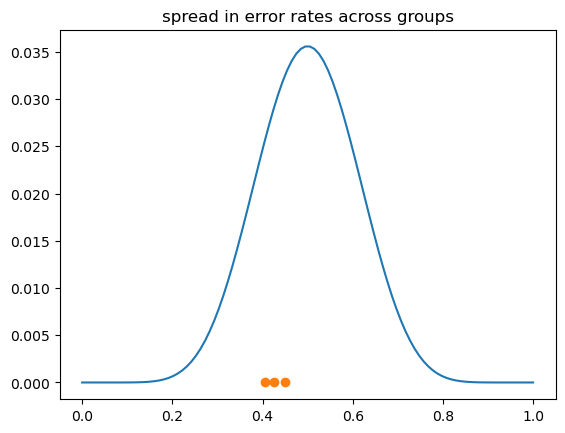

In [44]:
x = np.linspace(0,1,100)
y = stats.beta(a=10,b=10).pdf(x)
y = y / sum(y)

ps = stats.beta(a=5,b=5).rvs(3)

plt.plot(x,y)
plt.plot(ps,[0,0,0],'o')
plt.title("spread in error rates across groups");

So this distribution says that error rates can vary a lot from group-to-group. Anywhere between 0.2 and 0.8 is plausible. We don't usually get to see the super distribution. Instead, we get a little piece of it, or threee little pieces of it, in our studies. The next plot helps you visualize the hierarchical structure.

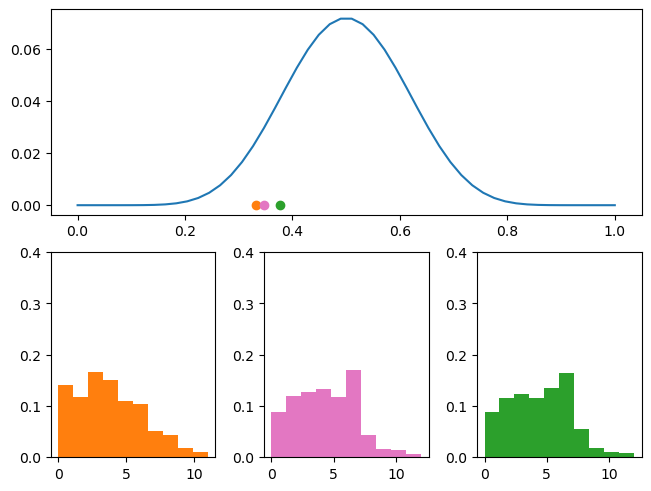

In [41]:
# population level parameters
# the error rate varys from group to group
# according to the beta distribution

p = 0.5
d = 20

dist_error_rate = stats.beta(a=p*d,b=(1-p)*d)

# subgroup level parameters
# each subgroup has 50 people
# and a dispersion of 10

sample_size = 1000
d = 10

# plot settings and generation

fig = plt.figure(constrained_layout=True).subplot_mosaic(
    """
    AAA
    BCD
    """)

x = np.linspace(0,1)
y = dist_error_rate.pdf(x)
y = y / sum(y)

ps = dist_error_rate.rvs(3)
ps = np.sort(ps)

fig['A'].plot(x,y)

plot_id = ['B','C','D']
plot_colors = ['tab:orange','tab:pink','tab:green']

for i in range(3):
    
    p = ps[i]

    data = stats.betabinom(n=12,a=p*d,b=(1-p)*d).rvs(sample_size)
    fig['A'].plot(p,[0],'o',color=plot_colors[i])
    fig[plot_id[i]].hist(data,bins=10,color=plot_colors[i],density=True)
    fig[plot_id[i]].set_ylim([0,0.4]);

So the bottom row depicts what three hypothetical samples might look like. Comparing all the samples gives us clues about what the super distribution might look like. But not very firm clues. If the super distribution is very spread out, then it's tough to generalize from one sample to the next. In this particular picture, the orange graph looks fairly different from the green graph. So this is one way generalization might fail.

## A trait that varies a little from group to group

But not every psychological phenomena varies so strongly. Sometimes there is pretty good consistently or uniformity in the human population. Here is a depict of effect that doesn't vary much.

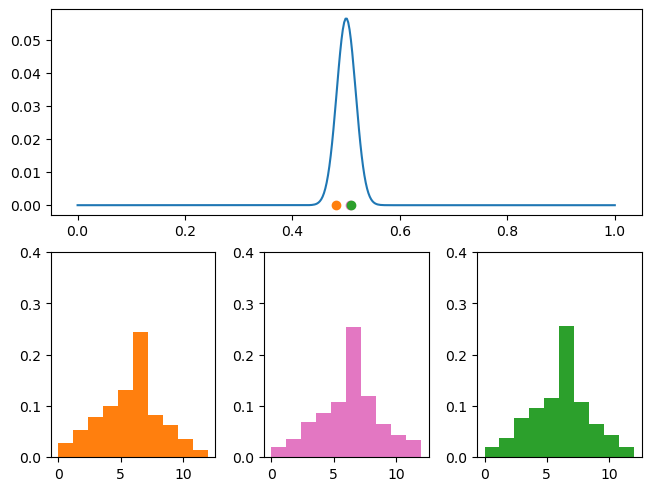

In [45]:
# population level parameters
# the error rate varys from group to group
# according to the beta distribution

p = 0.5
d = 800

dist_error_rate = stats.beta(a=p*d,b=(1-p)*d)

# subgroup level parameters
# each subgroup has 50 people
# and a dispersion of 10

sample_size = 1000
d = 10

# plot settings and generation

fig = plt.figure(constrained_layout=True).subplot_mosaic(
    """
    AAA
    BCD
    """)

x = np.linspace(0,1,400)
y = dist_error_rate.pdf(x)
y = y / sum(y)

ps = dist_error_rate.rvs(3)
ps = np.sort(ps)

fig['A'].plot(x,y)

plot_id = ['B','C','D']
plot_colors = ['tab:orange','tab:pink','tab:green']

for i in range(3):
    
    p = ps[i]

    data = stats.betabinom(n=12,a=p*d,b=(1-p)*d).rvs(sample_size)
    fig['A'].plot(p,[0],'o',color=plot_colors[i])
    fig[plot_id[i]].hist(data,bins=10,color=plot_colors[i],density=True)
    fig[plot_id[i]].set_ylim([0,0.4]);

Each particular sample looks fairly similar to all the others.

How do you know what kind of case you are in? How to tell if there is high or low variability? Well a bit of psychological theory can help you do the job. For example, suppose you think that social conformity is controlled by a particular cognitive system that is known to be [culturally sensitive](https://www2.psych.ubc.ca/~henrich/pdfs/WeirdPeople.pdf). Then you should expect a lot of variability across cultures. Or, you might think that there is some deep, evolved psychology to human beings that is very stable across time, culture, and location.

This tool cannot tell you what the right about of variability is. Nothing can. But it can help you visualize your assumptions and how they effect the inferential power of your experiment.

You might be curious, how much variability is there in the Asch experiment? Well, we do have data. A great exercise would be to estimate all 4 groups and compare them.

![image.png](https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/Asch_4_experiments.png)